In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import random

In [2]:
train_dir="./ml-100k/u1.base"
test_dir="./ml-100k/u1.test"

In [3]:
def readData(dir):
    data=[]
    with open(dir,"r") as file:
        for line in file:
            x=line
            tuple=[int(x.split()[0]),int(x.split()[1]),int(x.split()[2])]
            data.append(tuple)            
        return data
    

def getMatrix(data,user_num,item_num):
    R=np.zeros((user_num,item_num))
    for tuple in data:
        R[tuple[0]-1][tuple[1]-1]=tuple[2]
    return R
        

In [4]:
train_data=readData(train_dir)
test_data=readData(test_dir)

In [5]:
usr_num=np.max(train_data,0)[0]
item_num=np.max(train_data,0)[1]
R=getMatrix(train_data,usr_num,item_num)
R_test=getMatrix(test_data,usr_num,item_num)

In [8]:
def loss(R,P,Q):   
    usr_num=R.shape[0]
    item_num=R.shape[1]
    e=0
    x=(R>0)  #大于0的代表初始矩阵已经存在的评分
    loss=np.multiply(np.square(R-np.dot(P,Q)),x) 
    loss=np.sum(loss)
    total=np.sum(x)
    return loss


#lamda：正则项
def matrix_factorization(R,K,step,lamda,validation_data):
    usr_num=R.shape[0]
    item_num=R.shape[1]
    P=np.random.rand(usr_num,K)
    Q=np.random.rand(K,item_num)
    validation_loss=[]
    last_loss=0
    for s in range(step):
        for i in range(usr_num):
            tmp=Q                 #对P的每一行令偏导为0，求出闭式解
            inv=np.linalg.inv(np.dot(tmp,np.transpose(tmp))+lamda*np.eye(K))
            mul=np.dot(np.transpose(tmp),inv)
            P[i,:]=np.dot(R[i,:],mul)
        for j in range(item_num):
            tmp=P              #对Q的每一列令偏导为0，求出闭式解
            inv=np.linalg.inv(np.dot(np.transpose(tmp),tmp)+lamda*np.eye(K))
            mul=np.dot(inv,np.transpose(tmp))
            Q[:,j]=np.dot(mul,R[:,j])      
        #loss不带正则项，如果要看带正则项的，可以加上注释那段
        loss_val=loss(validation_data,P,Q) #np.sum(np.square(Q))*lamda/2+np.sum(np.square(P))*lamda/2
        if(abs(loss_val-last_loss)<0.0000001):
            return P,Q,validation_loss
        last_loss=loss_val
        validation_loss.append(loss_val)
        #print(loss_val)
    return P,Q,validation_loss




            
        

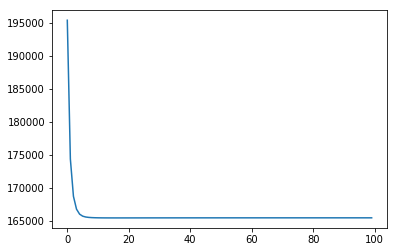

In [9]:
#以下的R是测试用的
'''
R = [
     [5,3,0,1],
     [4,0,0,1],
     [1,1,0,5],
     [1,0,0,4],
     [0,1,5,4],
    ]
R=np.array(R)
R_test=R
'''



K=10
lamda=0.001
step=100

P,Q,validation_loss=matrix_factorization(R,K,step,lamda,R_test)

plt.figure()
iter=range(len(validation_loss))
plt.plot(iter,validation_loss)
plt.show()
#print(np.dot(P,Q))
#error(R,P,Q)


In [12]:
def matrix_factorization_stochastic(R,alpha,K,step,lamda,validation_data):
    usr_num=R.shape[0]
    item_num=R.shape[1]
    P=np.random.rand(usr_num,K)  #初始化
    Q=np.random.rand(K,item_num) #初始化
    validation_loss=[]
    last_loss=0
    for i in range(step):
        sample=0
        user=0
        item=0
        while(sample==0):   #找到一个不等于0的
            user=random.randint(0,usr_num-1)
            item=random.randint(0,item_num-1)
            sample=R[user,item]
        e=R[user,item]-np.dot(P[user,:],Q[:,item])
        P[user,:]=P[user,:]+2*alpha*e*np.transpose(Q[:,item])-alpha*lamda*P[user,:]
        Q[:,item]=Q[:,item]+2*alpha*e*np.transpose(P[user,:])-alpha*lamda*Q[:,item]
        '''
        for k in range(K):                  #正常做法       
            P[i,k]=P[i,k]+2*alpha*e*Q[k,j]-alpha*lamda*P[i,k]  
            Q[k,j]=Q[k,j]+2*alpha*e*P[i,k]-alpha*lamda*Q[k,j]
         ''' 
        loss_val=loss(validation_data,P,Q)+np.sum(np.square(Q))*lamda/2+np.sum(np.square(P))*lamda/2
        validation_loss.append(loss_val)
        if(abs(loss_val-last_loss)<0.00001):
            return P,Q,validation_loss
        last_loss=loss_val
        #print(loss_val)
    return P,Q,validation_loss

In [13]:
'''
R = [
     [5,3,0,1],
     [4,0,0,1],
     [1,1,0,5],
     [1,0,0,4],
     [0,1,5,4],
    ]
R=np.array(R)
R_test=R
'''
alpha=0.01
K=2
lamda=0.02
step=10000

P,Q,validation_loss=matrix_factorization_stochastic(R,alpha,K,step,lamda,R_test)
#print(np.dot(P,Q))

[[ 4.46447566  2.36508394  1.83873973 ...,  1.28720872  1.39431135
   2.33993851]
 [ 2.45213469  1.41473787  0.97717617 ...,  0.42130212  0.41844925
   1.1472358 ]
 [ 1.26304529  0.66920224  0.52017085 ...,  0.36392708  0.39417628
   0.66187766]
 ..., 
 [ 1.96374168  0.96882064  0.82902691 ...,  0.74270286  0.8279195
   1.11449427]
 [ 3.73825518  1.99369377  1.53586427 ...,  1.04490861  1.12748346
   1.94341226]
 [ 4.31393508  2.24113756  1.78925187 ...,  1.35293722  1.47998866
   2.31374461]]


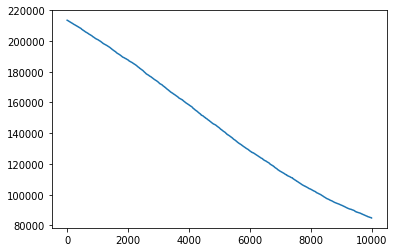

In [170]:
plt.figure()
iter=range(len(validation_loss))
plt.plot(iter,validation_loss)
plt.show()